In [1]:
from pathlib import Path

In [2]:
file_paths = "[../testdata/test1.nd2,../testdata/test2.nd2,../testdata/test3.nd2]"
output_dirs = "[../testdata/test1_output,../testdata/test2_output,../testdata/test3_output]"
common_output_dir = "../testdata/common_output"
metadata_paths : str = "[../testdata/test1_output/test1_metadata.yaml,../testdata/test2_output/test2_metadata.yaml,../testdata/test3_output/test3_metadata.yaml]"
corrected_filename = "shading_corrected.zarr"
profile_filename = "shading_profile.zarr"

mode = "additive"
strategy = "timewise" # or "all"
robust = False
local_subtraction_channels = "*DIA*"
local_subtraction_scaling = 0.1
local_subtraction_median_disk_size=4
num_cpus=10

In [3]:
assert mode in ["multiplicative", "additive"], "mode must be either 'multiplicative' or 'additive'"
assert strategy in ["timewise", "all"], "strategy must be either 'timewise' or 'all'"

In [4]:
import yaml

def to_path(x):
    return [Path(i).absolute() for i in yaml.safe_load(x)]

_file_paths = to_path(file_paths)
_output_dirs = to_path(output_dirs)
_metadata_paths = to_path(metadata_paths)
_common_output_dir = Path(common_output_dir).absolute()
_common_output_dir.mkdir(exist_ok=True)
assert len(_file_paths) == len(_output_dirs) == len(_metadata_paths), "file_paths, output_dirs, and metadata_paths must have the same length"

In [5]:
import ray
ray.shutdown()
ray.init(num_cpus=num_cpus)

/home/fukai/.pyenv/versions/miniforge3-latest/envs/microflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-19 16:44:00,437	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-19 16:44:09,925	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.9.0', ray_commit='{{RAY_COMMIT_SHA}}', protocol_version=None)

# Import packages and define functions

In [6]:
from aicsimageio import AICSImage
from matplotlib import pyplot as plt
import numpy as np
from dask import array as da
import re
import zarr
import yaml
from skimage import transform, filters, morphology
from utils import read_mosaic_image, show_ray_progress, open_zarr_with_synchronizer

import fnmatch

In [7]:
metadatas = [
    yaml.safe_load(Path(metadata_path).read_text())
    for metadata_path in _metadata_paths    
]

def to_unique_channel_name(channel_names):
    channel_names = channel_names.copy()
    duplicates = {
        name: channel_names.count(name)
        for name in channel_names
        if channel_names.count(name) > 1
    }
    for name in duplicates.keys():
        for i in range(1, duplicates[name]+1):
            channel_names[channel_names.index(name)] = f"{name}_{i}"
    return channel_names

channel_namess = [
    metadata["channel_names"] for metadata in metadatas]
unique_channel_namess = [
    to_unique_channel_name(channel_names) for channel_names in channel_namess]
mosaic_dims = [
    metadata["mosaic_dim"] for metadata in metadatas]
print(channel_namess, mosaic_dims)
unique_channel_names_all = {}
for ucn, cn in zip(unique_channel_namess, channel_namess): 
    unique_channel_names_all.update({ k: v for k,v in zip(ucn, cn)})
unique_channel_names_all
print(unique_channel_names_all)

[['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS'], ['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS'], ['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS']] ['scene', 'scene', 'scene']
{'10x_Fukai_DIA_IS_1': '10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS_2': '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS': '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS': '10x_Fukai_EGFP_IS'}


# Shading correction

## Open images 

In [8]:
aics_images = [ AICSImage(file_path,reconstruct_mosaic=False) for file_path in _file_paths ]
images = [
    read_mosaic_image(aics_image, mosaic_dim, "TCZYX")
    for aics_image, mosaic_dim in zip(aics_images, mosaic_dims)
]

In [9]:
images[0].shape # (M, T, C, Z, Y, X)

(48, 1, 4, 1, 2296, 2656)

In [10]:
assert all(images[0].shape[-3:] == image.shape[-3:] for image in images), "All images must have the same shape"

## Output files

In [11]:
corrected_zarrs = []
for image, output_dir in zip(images, _output_dirs):
    chunks = [1] * len(image.shape[:-2]) + list(image.shape[-2:])
    zarr_path = output_dir/corrected_filename
    output_zarr = open_zarr_with_synchronizer(zarr_path, shape=image.shape, chunks=chunks, dtype=np.float32)
    corrected_zarrs.append(output_zarr)

In [12]:
if strategy == "all":
    profile_path = _common_output_dir/profile_filename
    profile_shape = (1, 1, len(unique_channel_names_all), *images[0].shape[-3:])
    profile_zarr = open_zarr_with_synchronizer(profile_path,
                             shape=profile_shape, 
                             dtype=np.float32)
elif strategy == "timewise":
    profile_zarrs = []
    for output_dir, image in zip(_output_dirs, images):    
        profile_path = output_dir/profile_filename
        profile_zarr = open_zarr_with_synchronizer(profile_path,
                                 shape=[1]+list(image.shape[1:]),#TCZYX
                                 dtype=np.float32)
        profile_zarrs.append(profile_zarr)

## Estimate and correct shading

In [13]:
def estimate_median_profile(images, axis, robust=False, deviation_factor=2., keepdims=True):
    if robust:
        deviation = da.abs(da.median(images, axis=axis, keepdims=True) - images)
        median_deviation = da.median(da.ravel(deviation), axis=0)
        bg = da.nanmedian(da.where(deviation < median_deviation * deviation_factor, images, np.nan), axis=axis, keepdims=keepdims)
    else:
        bg = da.median(images, axis=axis, keepdims=keepdims)
    return bg

### Compute the median profile 

In [14]:
if strategy == "all":
    for j,Cn in enumerate(unique_channel_names_all.keys()):
        channel_images = [
            image[:,:,unique_channel_names.index(Cn),...] 
            for image, unique_channel_names in zip(images, unique_channel_namess) 
            if Cn in unique_channel_names
        ]
        channel_images = [
            image.reshape(-1, *image.shape[2:]) for image in channel_images
        ]
        background = estimate_median_profile(da.concatenate(channel_images), robust,keepdims=False).compute() # median over M and T
        profile_zarr[0,0,j] = background
    profile_zarr.attrs["unique_channel_names"], profile_zarr.attrs["channel_names"] = zip(*unique_channel_names_all.items())
elif strategy == "timewise":
    @ray.remote
    def process_image(profile_zarr, image, t, c):
        profile_zarr[0,t,c, ... ] = estimate_median_profile(image[:,t,c,...], robust, keepdims=False)
    ress = []
    for profile_zarr, image in zip(profile_zarrs, images):
        for t, c in np.ndindex(image.shape[1:3]):
            ress.append(process_image.remote(profile_zarr, image, t, c))
    show_ray_progress(ress)

100%|██████████| 14/14 [02:08<00:00,  9.17s/it]


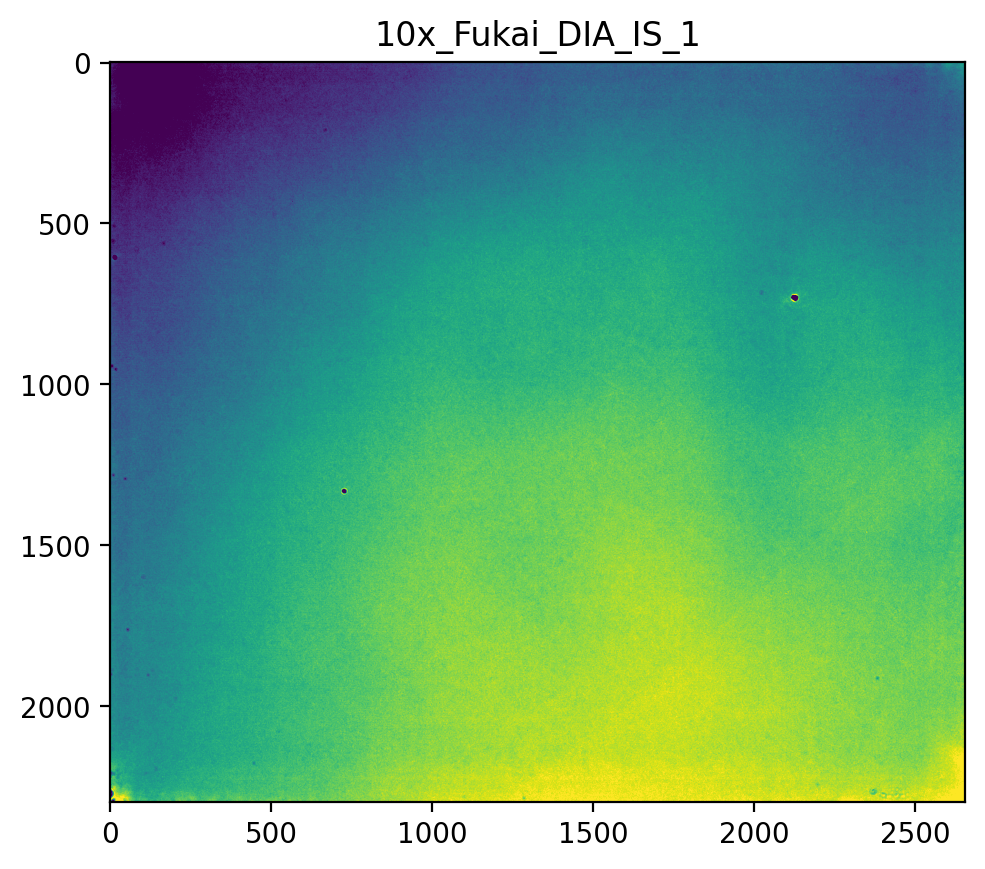

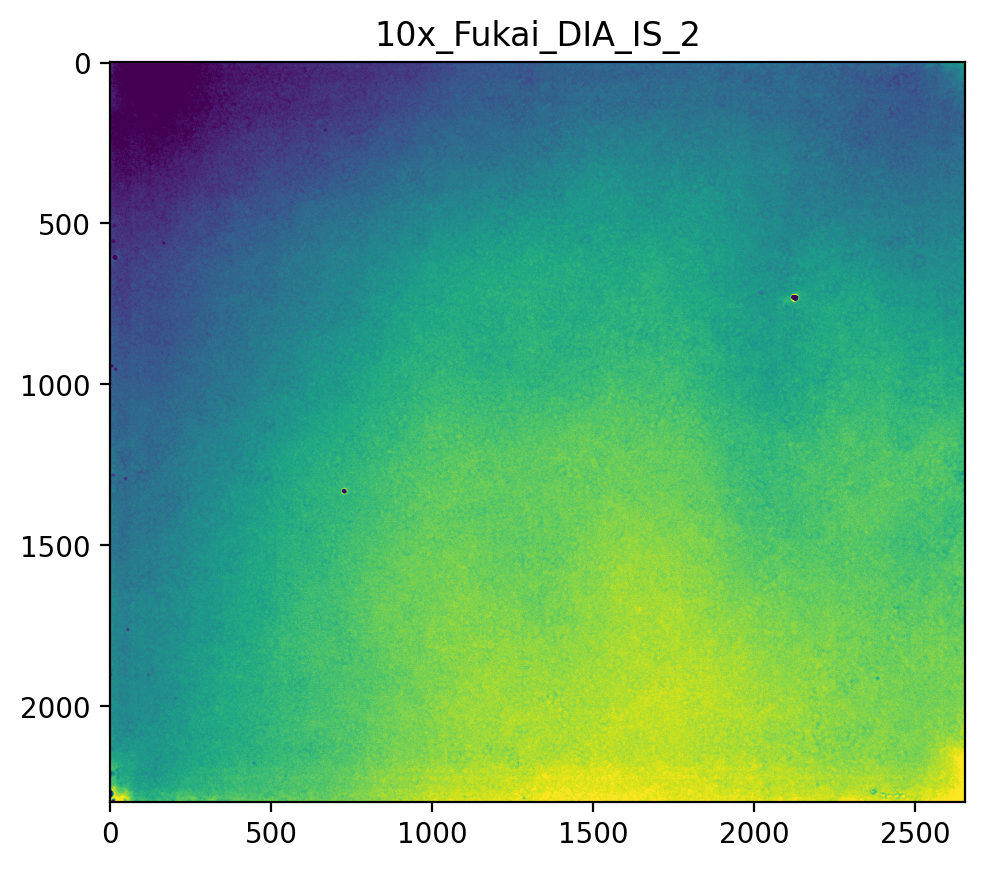

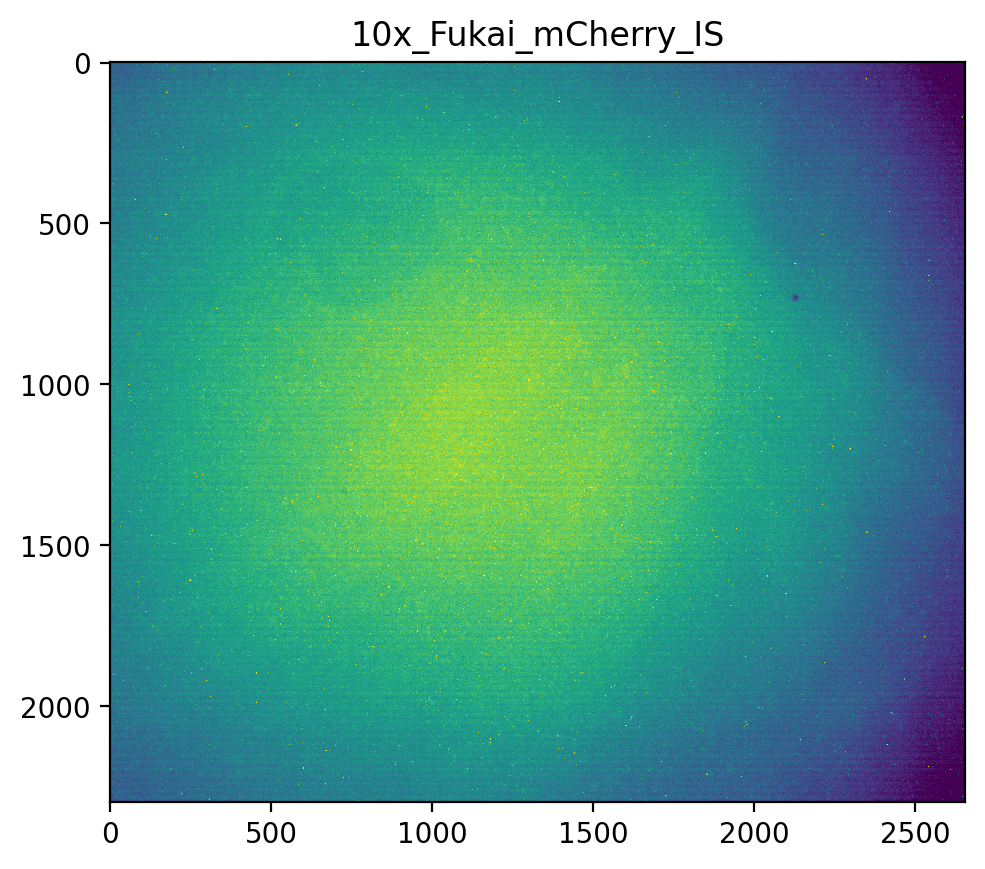

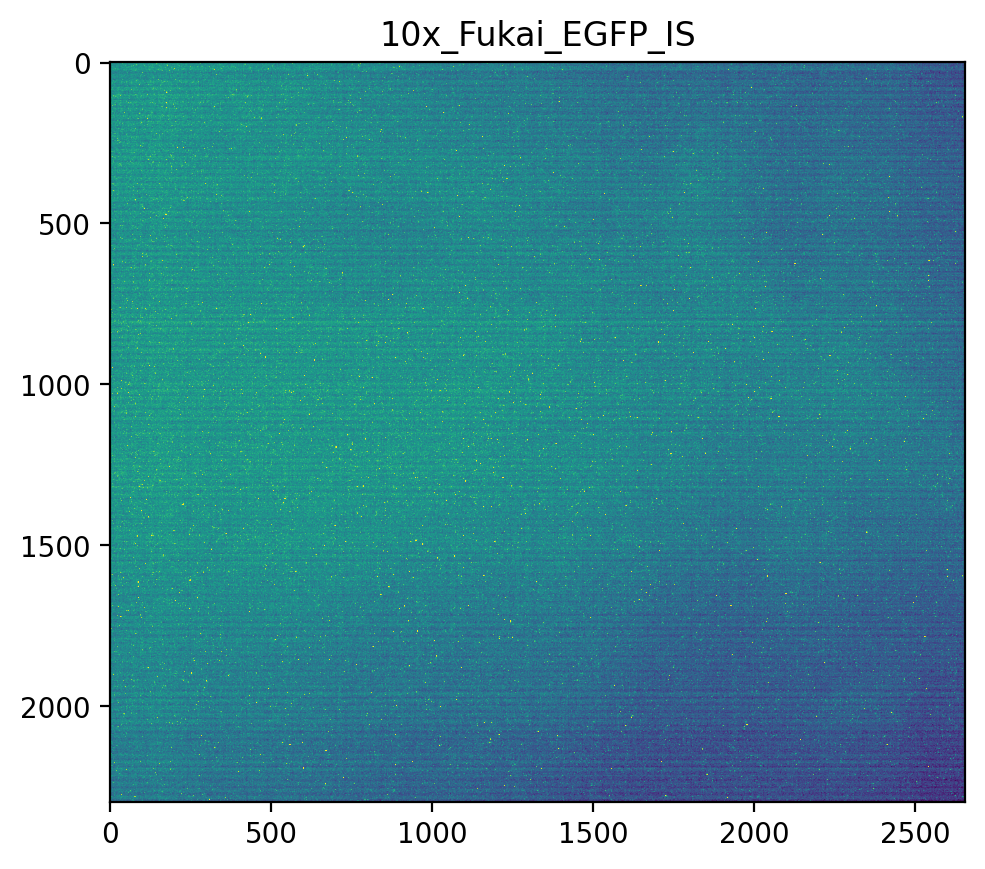

In [15]:
profile_zarr = profile_zarrs[0]
if strategy == "timewise":
    channel_names = unique_channel_namess[0]
else:
    channel_names = list(unique_channel_names_all.keys())
for j, Cn in enumerate(channel_names):
    m, M = np.percentile(profile_zarr[0,0,j], (1, 99))
    plt.imshow(profile_zarr[0,0,j,0], vmin=m, vmax=M)
    plt.title(Cn)
    plt.show()

### Shading correction

#### Define functions

In [16]:
def scaled_filter(im2d,scale,fn,anti_aliasing=True):
    """ apply filter for scaled image and resize to original size """
    shape = im2d.shape
    im2d = np.array(im2d, dtype=np.float32)
    im2d = transform.rescale(im2d, 
        scale,
        anti_aliasing=anti_aliasing,
        preserve_range=True)
    im2d = fn(im2d)
    return transform.resize(im2d,shape,
                preserve_range=True)

def local_subtraction_2d_ignore_zero(im2d, scaling=0.1, median_disk_size=4):
    def median_filter(im):
        return filters.median(
                    im,morphology.disk(median_disk_size)
                )
    assert np.all(np.array(im2d.shape[:-2])==1)
    if np.count_nonzero(im2d) == 0:
        return im2d
    return im2d-scaled_filter(im2d, scaling, median_filter, anti_aliasing=True)

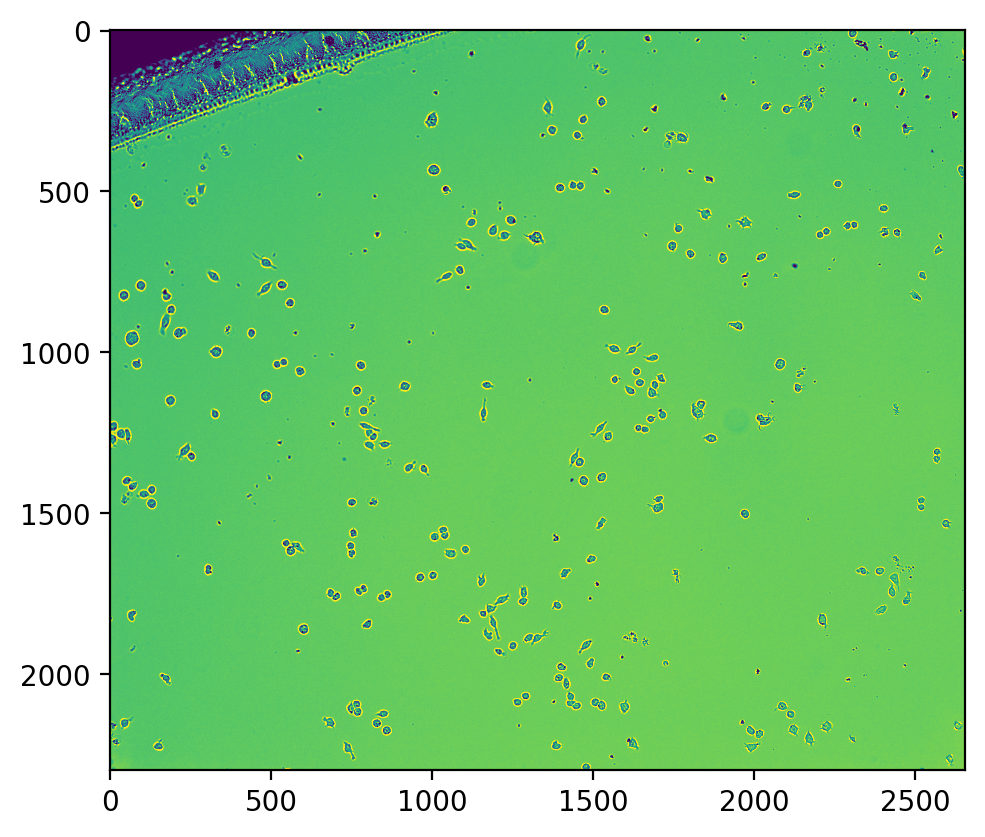

In [17]:
vmin, vmax = np.percentile(np.ravel(images[0][0,0,0]), (1, 99))
plt.imshow(images[0][0,0,0,0], vmin=vmin, vmax=vmax)

In [18]:
@ray.remote
def process_chunk(corrected_zarr, image, profile_zarr, ind, do_local_subtraction):
    if mode == "multiplicative":
        image = np.array((image / profile_zarr)[ind]).astype(np.float32)
    elif mode == "additive":
        image = np.array((image - profile_zarr)[ind]).astype(np.float32)
    if do_local_subtraction:
        image2 = np.empty_like(image)
        for inds in np.ndindex(image.shape[:-2]):
            image2[inds] = local_subtraction_2d_ignore_zero(
                image[inds], local_subtraction_scaling, 
                local_subtraction_median_disk_size)
        image = image2
    corrected_zarr[ind] = image

#### Test with only one image

In [19]:
show_ray_progress([process_chunk.remote(corrected_zarrs[1], images[1], profile_zarrs[1], (0,1,0), True)])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


[None]

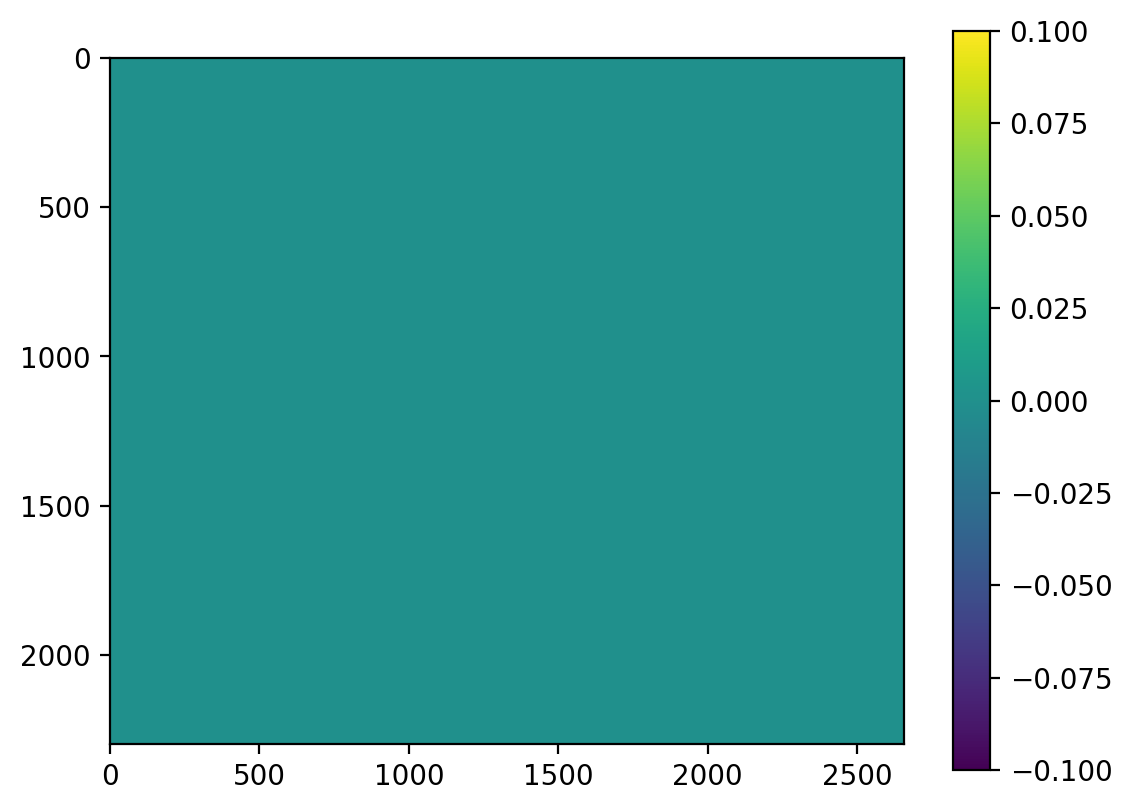

In [20]:
vmin, vmax = np.percentile(np.ravel(corrected_zarrs[0][0,0,0,0]), (0.0001, 99.9999))
plt.imshow(corrected_zarrs[0][0,0,0,0], vmin=vmin, vmax=vmax)
plt.colorbar()

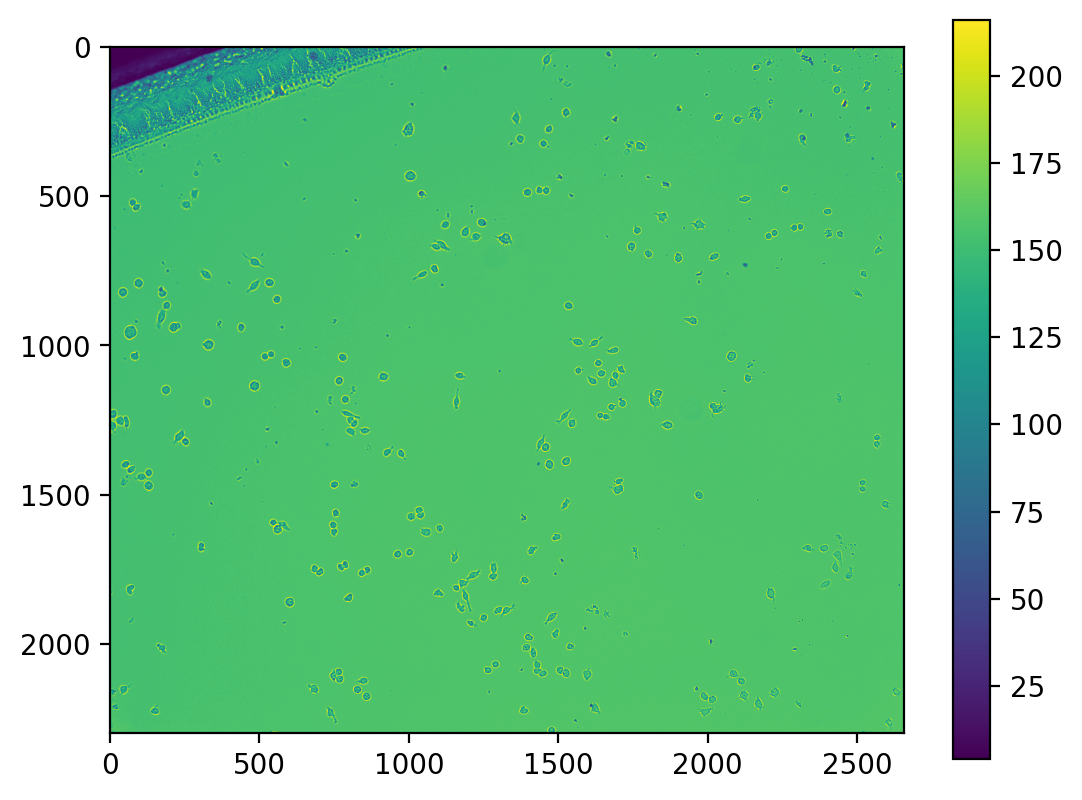

In [21]:
diff = images[0][0,0,0,0]-corrected_zarrs[0][0,0,0,0]
vmin, vmax = np.percentile(np.ravel(diff), (0.1, 99.9))
plt.imshow(diff,vmin=vmin, vmax=vmax)
plt.colorbar()

#### Process all images

In [22]:
strategy

'timewise'

In [23]:
local_subtraction_channels

'*DIA*'

In [24]:
def match_pattern(pattern, string):
    return any(fnmatch.fnmatch(string, p) for p in pattern.split(", "))

pattern1 = '*DIA*'
pattern2 = '*DIA*, *EGFP*'

assert match_pattern(pattern1, "10X_Fukai_DIA_IS")  
assert not match_pattern(pattern1, "10X_Fukai_EGFP_IS")  
assert match_pattern(pattern2, "10X_Fukai_DIA_IS")  
assert match_pattern(pattern2, "10X_Fukai_EGFP_IS")  

In [25]:
if strategy == "timewise":
    ress = []
    for corrected_zarr, image, profile_zarr, channel_names in zip(corrected_zarrs, images, profile_zarrs, channel_namess):
        for (m,t,c) in np.ndindex(image.shape[:3]): # M, T, C
            do_local_subtraction = local_subtraction_channels == "all" or match_pattern(local_subtraction_channels, channel_names[c])
            ress.append(process_chunk.remote(corrected_zarr, image, profile_zarr, (m,t,c), do_local_subtraction))
    show_ray_progress(ress)
else:
    raise NotImplementedError

100%|██████████| 672/672 [01:21<00:00,  8.21it/s]


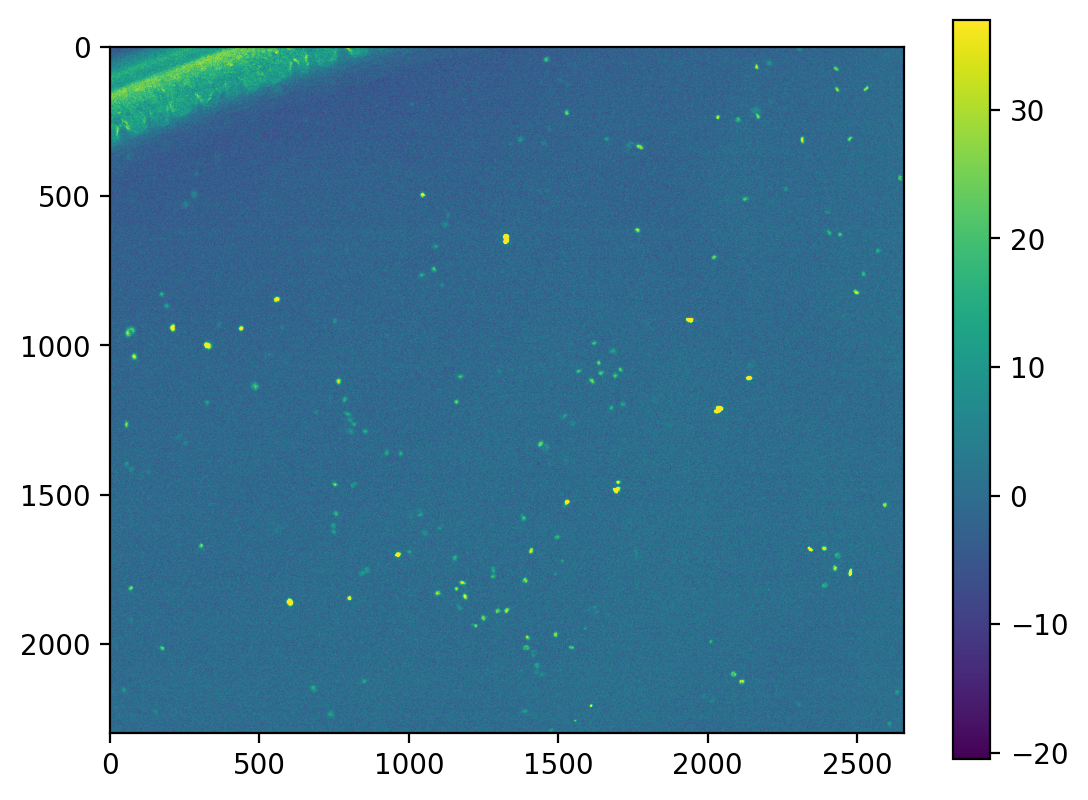

In [26]:
im = corrected_zarrs[0][0,0,2,0]
vmin, vmax = np.percentile(np.ravel(im), (0.1, 99.9))
plt.imshow(im,vmin=vmin, vmax=vmax)
plt.colorbar()